
# Classification and localization task

In this section, we will combine image classification task, which predicts a global decision about an image, with a more local information. Namely locating the main object of the image using a bounding box.
Localization is often formulated as a regression task, where the aim is to predict a continuous value (or more) that locates spatially an object or a feature of interest.

The overall framework will be trained using a multi-task loss (classification and localization) using two output layers. 
Constraining the number of objects in the scene (for example one) allows us to use a rather simple approach to localize the objects. That is, an output layer with a fixed number of neurons (4 in this example, to regress the 4 boundaries of the bounding box).

In order to assess the performance of the model, we will use two metrics: Accuracy for the classification task and mean IoU (intersection-over-union) which measures the overlap between the ground-truth box and the predicted one. the mean IoU is bounded between 0 and 1 with larger values indicating larger overlap and better localization accuracy.
![alt text](https://www.researchgate.net/profile/Mathias_Rieder/publication/334363440/figure/fig1/AS:816456560308224@1571669821158/Comparison-of-semantic-segmentation-classification-and-localization-object-detection_W640.jpg)

We will generalize the pipeline we defined earlier, to a more general task (multi-task learning).

 The lab is organized as following:

  1.1 Implementation of a simple multi-task model in Keras;

  1.2 Data prepartation (Dataset normalization, splitting and label pre-processing; 

  1.3 Implementation of the multi-task loss in Keras;

  1.4 Model training;

  1.5 Model testing.





In [ ]:
import os
import re
import zipfile
import xml.etree.ElementTree as ET

import numpy as np
import tensorflow as tf
from tensorflow import keras
from PIL import Image


import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
# For measuring the inference time.
import time

# Print Tensorflow version
print(tf.__version__)

# Check available GPU devices.
print("The following GPU devices are available: %s" % tf.test.gpu_device_name())

2.12.0
The following GPU devices are available: /device:GPU:0


## Building the ResNet50 backbone

The model uses a ResNet based backbone, using feature of the last layers. In the example we use ResNet50 as the backbone, and return the feature maps.

In [ ]:
def get_backbone():
    """Builds ResNet50 with pre-trained imagenet weights"""
    backbone = keras.applications.ResNet50(include_top=False, weights='imagenet', input_shape=[224, 224, 3])
    return keras.Model(inputs=backbone.inputs, outputs=backbone.outputs)


def build_head(output_filters, bias_init):
    """Builds the class/box predictions head.

    Arguments:
      output_filters: Number of convolution filters in the final layer.
      bias_init: Bias Initializer for the final convolution layer.

    Returns:
      A keras sequential model representing either the classification
        or the box regression head depending on `output_filters`.
    """
    head = keras.Sequential([keras.Input(shape=[None, None, 18432])]) # 8192
    kernel_init = tf.initializers.RandomNormal(0.0, 0.01)
    head.add(keras.layers.Dense(output_filters,kernel_initializer=kernel_init,bias_initializer=bias_init))
    return head

# Model

![alt text](http://i.imgur.com/YByjh5S.png)

### Extending ResNet model to add the extra bounding-box regression layer:

In order to predict both the class and the location of the main object of the scene, we need to extend ResNet to add a new output layer. This layer will be initialized randomly. However, we can still import the image-net weights for the rest of the original layers.

In [ ]:
class Detection(keras.Model):
    """A subclassed Keras model implementing the FastRCNN architecture.

    Attributes:
      num_classes: Number of classes in the dataset.
      backbone: The backbone to build the feature.
    """

    def __init__(self, num_classes, backbone=None, **kwargs):
        super().__init__(name="Detection", **kwargs)
        self.backbone = backbone if backbone else get_backbone()
        
        self.num_classes = num_classes

        prior_probability = tf.constant_initializer(-np.log((1 - 0.01) / 0.01))

        # dense layer for classification
        self.cls_head = build_head(num_classes, prior_probability)

        # dense layer for bounding box prediction
        self.box_head = build_head(4, "zeros") 

        # define layers that will be use later
        self.flatten = keras.layers.Flatten()
        self.avgpool = tf.keras.layers.AveragePooling2D()

    def call(self, image, training=False):

        # extract features for backbone
        feature = self.backbone(image, training=training)
        N = tf.shape(image)[0]
        
        feature = self.avgpool(feature)
        feature = self.flatten(feature)
        
        # prediction based on features
        cls_outputs = tf.reshape(self.cls_head(feature), [N,-1, self.num_classes])
        box_outputs = tf.reshape(self.box_head(feature), [N,-1, 4])

        # return predictions, first 4 parameters are bounding box and last 10 are class prediction.
        return tf.concat([box_outputs, tf.nn.softmax(cls_outputs)], axis=-1)

## Dataset: IcubWorld Transformations

The [iCubWorld](https://robotology.github.io/iCubWorld/#datasets) dataset is made up of images sapled from video sequences, each image contains just one object. So we have a fixed number of possible prediction per image, only one.

10 classes of common objects:
- multiple instances per object class, different poses and viewpoints
- 2-day acquisition

7 instances per object are used for training and 3 instances to build a validation set (\~10k:\~4k)

Dataset is organized as:
- train:
  - img
    - class1
      - images

    - class2
      - images
    - ...
  - ann
    - class1
      - xml gt
    - class2
      - xml gt
- val
  - img
    - class1
      - images
    - class2
      - images
  - ann
    - class1
      - xml gt
    - class2
      - xml gt
 
 
 Annotations are organized in separate file per image, and specifies:
 - the object class
 - the bounding box coordinates


### Download data

In [ ]:
!wget -O train.zip https://www.dropbox.com/s/car3l28w4pkdqgq/train.zip?dl=0
!unzip train.zip
!wget val.zip https://www.dropbox.com/s/yxbmiqus8vtb2f6/val.zip?dl=0
!unzip val.zip?dl=0


Output streaming troncato alle ultime 5000 righe.
  inflating: val/ann/ringbinder/012725.xml  
  inflating: val/ann/ringbinder/012726.xml  
  inflating: val/ann/ringbinder/012727.xml  
  inflating: val/ann/ringbinder/012728.xml  
  inflating: val/ann/ringbinder/012729.xml  
  inflating: val/ann/ringbinder/012730.xml  
  inflating: val/ann/ringbinder/012731.xml  
  inflating: val/ann/ringbinder/012732.xml  
  inflating: val/ann/ringbinder/012733.xml  
  inflating: val/ann/ringbinder/012734.xml  
  inflating: val/ann/ringbinder/012735.xml  
  inflating: val/ann/ringbinder/012736.xml  
  inflating: val/ann/ringbinder/012737.xml  
  inflating: val/ann/ringbinder/012738.xml  
  inflating: val/ann/ringbinder/012739.xml  
  inflating: val/ann/ringbinder/012740.xml  
  inflating: val/ann/ringbinder/012741.xml  
  inflating: val/ann/ringbinder/012742.xml  
  inflating: val/ann/ringbinder/012743.xml  
  inflating: val/ann/ringbinder/012744.xml  
  inflating: val/ann/ringbinder/012745.xml  
  inf

## Prepare data
* Images are preprocessed so that are compatible con ImageNet weights
* Prepare class labels and bounding box


Bounding boxes can be represented in multiple ways, the most common formats are:



*   Storing the coordinates of the corners [xmin, ymin, xmax, ymax]
*   Storing the coordinates of the center and the box dimensions [x, y, width, height]

Since we require both formats, we will be implementing functions for converting between the formats.



In [ ]:
def swap_xy(boxes):
    """Swaps order the of x and y coordinates of the boxes.

    Arguments:
      boxes: A tensor with shape `(num_boxes, 4)` representing bounding boxes.

    Returns:
      swapped boxes with shape same as that of boxes.
    """
    return tf.stack([boxes[:, 1], boxes[:, 0], boxes[:, 3], boxes[:, 2]], axis=-1)


def convert_to_xywh(boxes):
    """Changes the box format to center, width and height.

    Arguments:
      boxes: A tensor of rank 2 or higher with a shape of `(..., num_boxes, 4)`
        representing bounding boxes where each box is of the format
        `[xmin, ymin, xmax, ymax]`.

    Returns:
      converted boxes with shape same as that of boxes.
    """
    return tf.concat([(boxes[..., :2] + boxes[..., 2:]) / 2.0, boxes[..., 2:] - boxes[..., :2]], axis=-1,)


def convert_to_corners(boxes):
    """Changes the box format to corner coordinates

    Arguments:
      boxes: A tensor of rank 2 or higher with a shape of `(..., num_boxes, 4)`
        representing bounding boxes where each box is of the format
        `[x, y, width, height]`.

    Returns:
      converted boxes with shape same as that of boxes.
    """
    return tf.concat([boxes[..., :2] - boxes[..., 2:] / 2.0, boxes[..., :2] + boxes[..., 2:] / 2.0], axis=-1,)


def encode_sample( image_shape, gt_boxes, cls_ids):
    """Creates box and classification targets for a single sample"""
    cls_ids = tf.cast(cls_ids, dtype=tf.float32)
    cls_target = tf.expand_dims(cls_ids, axis=-1)
    return tf.concat([gt_boxes, cls_target], axis=-1)


def encode_batch( batch_images, gt_boxes, cls_ids):
    """Creates box and classification targets for a batch"""
    images_shape = tf.shape(batch_images)
    batch_size = images_shape[0]

    labels = tf.TensorArray(dtype=tf.float32, size=batch_size, dynamic_size=True)
    for i in range(batch_size):
        label = encode_sample(images_shape, gt_boxes[i], cls_ids[i])
        labels = labels.write(i, label)

    # normalize image according to ImageNet weights
    batch_images = tf.keras.applications.resnet.preprocess_input(batch_images)

    return batch_images, labels.stack()


  

Definition of the dataset in Keras.
* Load the image given the path to it
* Load bounding box coordinates (1 for image), convert and normalize them to be in $[0, 1]$
* Load class label (extracted from the path)

In [ ]:

class IcubDataset(keras.utils.Sequence) :
  
  def __init__(self, root) :
    self.image_dir=os.path.join(root,'img')
    self.annotation_dir=os.path.join(root,'ann')
    self.classes_count=0
    self.classes = []
        
    #same for images and annotation files
    self.file_names = []
    self.total_number=0
      
    # count number of classes and number of instances
    for class_ in os.listdir(self.image_dir):
      self.classes.append(class_)
      self.file_names.append(os.listdir(os.path.join(self.image_dir,class_)))
      self.classes_count+=1
      self.total_number+= len(os.listdir(os.path.join(self.image_dir,class_)))
      self.per_class=int(self.total_number/self.classes_count)
    
    
  def __len__(self) :
    return self.total_number

  def get_box(self,class_id,img_index):
    to_class = os.path.join(self.annotation_dir,self.classes[class_id])
    ann_file =os.path.join(to_class,self.file_names[class_id][img_index])
    ann_file = ann_file.split('.')[0] + '.xml'

    # extract bounding box from XML file
    tree = ET.parse(ann_file)
    box = tree.find('object').find('bndbox')
    xmin = int(box.find('xmin').text)
    xmax = int(box.find('xmax').text)
    ymin = int(box.find('ymin').text)
    ymax = int(box.find('ymax').text)

    # convert and normalize it
    bbox = np.expand_dims(np.stack([xmin, ymin, xmax, ymax]), axis=0 )
    return convert_to_xywh(bbox)/224
  
  def __getitem__(self, idx) :
    class_id = int(idx/self.per_class)
    img_index = int(idx%self.per_class)
    to_class = os.path.join(self.image_dir,self.classes[class_id])
    img_path = os.path.join(to_class,self.file_names[class_id][img_index])

    # load RGB image and labels
    img = Image.open(img_path).convert('RGB')
    box = self.get_box(class_id,img_index)
    # normalize center, width and height with image dimensions
    class_id = np.expand_dims(np.array(class_id), axis=0)
    return img, box, class_id

In [ ]:

def visualize_detections(image, boxes, classes, scores=None, figsize=(7, 7), linewidth=1, color=[0, 0.5, 1]):
    """Visualize Detections"""
    image = np.array(image, dtype=np.uint8)
    plt.figure(figsize=figsize)
    plt.axis("off")
    plt.imshow(image)
    ax = plt.gca()

    if scores is None:
      scores = np.ones(classes.shape)

    for box, _cls, score in zip(boxes, classes, scores):
        text = "{}: {:.2f}".format(_cls, score)
        x1, y1, x2, y2 = box
        w, h = x2 - x1, y2 - y1
        patch = plt.Rectangle(
            [x1, y1], w, h, fill=False, edgecolor=color, linewidth=linewidth
        )
        ax.add_patch(patch)
        ax.text(
            x1,
            y1,
            text,
            bbox={"facecolor": color, "alpha": 0.4},
            clip_box=ax.clipbox,
            clip_on=True,
        )
    plt.show()
    return ax

# Training the model

Define the pipeline for both training and validation data: load images and annotations, shuffle and batch it. By default no data augmentation is performed. Random flipping and rotation can be applied, but in that case also the buonding box should be transformed too.

In [ ]:

def create_data_pipeline(dataset, batch_size, shuffle=None):

  if shuffle is None:
    shuffle = 8 * batch_size

  autotune = tf.data.AUTOTUNE
  dataset = dataset.shuffle(shuffle)
  dataset = dataset.batch(batch_size=batch_size, drop_remainder=True) 
  dataset = dataset.map(encode_batch) 
  dataset = dataset.prefetch(autotune)
  return dataset


# create pipeline for training data
icub_train = IcubDataset("train")
def train_generator():
    for i in range(len(icub_train)):
        yield icub_train.__getitem__(i)

train_dataset = tf.data.Dataset.from_generator(train_generator, output_signature=(
        tf.TensorSpec(shape=(224,224,3), dtype=tf.float32),
        tf.TensorSpec(shape=(1,4), dtype=tf.float32),
        tf.TensorSpec(shape=(1), dtype=tf.float32))) 
train_dataset_pipe = create_data_pipeline(train_dataset, 32)


# create pipeline for validation data

icub_val = IcubDataset("val")
def val_generator():
    for i in range(len(icub_val)):
        yield icub_val.__getitem__(i)

val_dataset = tf.data.Dataset.from_generator(val_generator, output_signature=(
        tf.TensorSpec(shape=(224, 224, 3), dtype=tf.float32),
        tf.TensorSpec(shape=(1,4), dtype=tf.float32),
        tf.TensorSpec(shape=(1), dtype=tf.float32)))
val_dataset_pipe = create_data_pipeline(val_dataset, 1, 1000)




## Define the multi-task loss

The loss function for the classification task is the [Categorical cross-entropy](https://www.tensorflow.org/api_docs/python/tf/keras/losses/CategoricalCrossentropy). While for the regression task the [L2 loss](https://www.tensorflow.org/api_docs/python/tf/keras/metrics/mean_squared_error) is typically chosen.

In [ ]:

# callback to save the weight when the model improve on the validation loss
model_dir = "./"
callbacks_list = [
    tf.keras.callbacks.ModelCheckpoint(
        filepath=os.path.join(model_dir, "weights" + "_epoch_{epoch}"),
        monitor="val_loss",
        save_best_only=True,
        save_weights_only=True,
        verbose=1,
    )
]


# create model and compile it with adam optimizer
num_classes = 10

resnet50_backbone =  get_backbone()

def multi_task_loss(y_true, y_pred):
  y_pred = tf.cast(y_pred, dtype=tf.float32)
  box_labels = y_true[..., :4] # first 4 output are box parameters
  box_predictions = # ... Extract the prediction of the bounding box 

  # encode integer label to be one-hot 
  cls_labels = tf.one_hot(
            tf.cast(y_true[..., -1], dtype=tf.int32),
            depth=num_classes,
            dtype=tf.float32,
        )
  

  cls_predictions = y_pred[..., 4:]
  
  # compute loss
  clf_loss = keras.losses.categorical_crossentropy(cls_labels, cls_predictions)
  box_loss = # ... Compute the L2 loss 

  # sum the losses and take the mean
  loss = tf.reduce_mean(box_loss + clf_loss)
  return loss


# create model
model = Detection(num_classes, resnet50_backbone)
lr = 0.0001

optimizer = tf.optimizers.Adam(learning_rate=lr)
model.compile(loss=multi_task_loss, optimizer=optimizer)


94765736/94765736 [==============================] - 6s 0us/step


<font color='red'> What if you change the learning rate, optimizer? What's happen if you make the network deeper?</font>

In [ ]:

# train for 10 epochs
epochs = 10

model.fit(
    train_dataset_pipe,
    validation_data=val_dataset_pipe,
    epochs=epochs,
    callbacks=callbacks_list,
    verbose=1,
)


    315/Unknown - 182s 412ms/step - loss: 1.1702
Epoch 1: val_loss improved from inf to 15.16009, saving model to ./weights_epoch_1
315/315 [==============================] - 267s 683ms/step - loss: 1.1702 - val_loss: 15.1601


# Loading weights
Load the weights of the best model found with respect to the validation loss

In [ ]:
# load best weights
latest_checkpoint = tf.train.latest_checkpoint(model_dir)
model.load_weights(latest_checkpoint)

# Building inference model


Decode output of the model:


*   From one-hot to label of the classes
*   [Non-maxima suppresion](https://www.tensorflow.org/api_docs/python/tf/image/non_max_suppression) of the bounding box: in this case we are assuming 1 prediction per image, so we do not need it.

Non-maxima suppresion makes more sense if you have multiple objects to detected inside a single image: you can chose the maximum number of predictions in a image, the IoU threshold to consider a detection valid, ecc.

In [ ]:


def decode_prediction(prediction):

  bbox_pred, cls_pred = prediction[..., :4], prediction[..., 4:]
  cls_decoded = np.argmax(cls_pred, axis=-1) # axis=-1 because just one image
  
  bbox_pred = tf.cast(bbox_pred, dtype=tf.float32)
  cls_decoded = tf.cast(cls_decoded, dtype=tf.float32)
  cls_decoded.numpy()[0]

  best_score_idx  = cls_decoded[0][0].numpy().astype(np.int32)

  bbox_selected = bbox_pred.numpy()  
  return cls_decoded, bbox_selected, cls_pred[:,0,best_score_idx]

1/1 [==============================] - 0s 24ms/step
<class 'numpy.int32'>


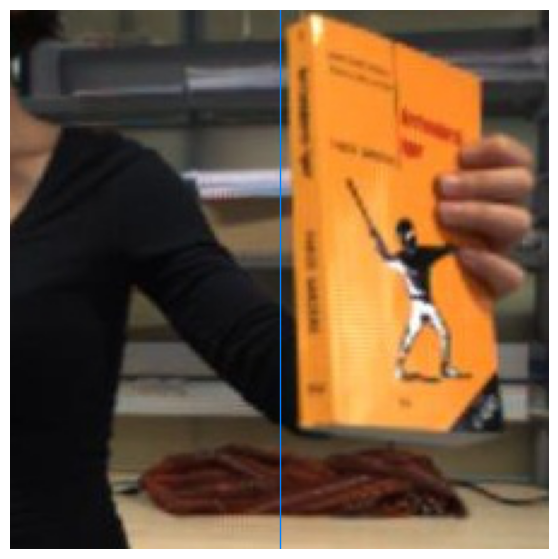

1/1 [==============================] - 0s 29ms/step
<class 'numpy.int32'>


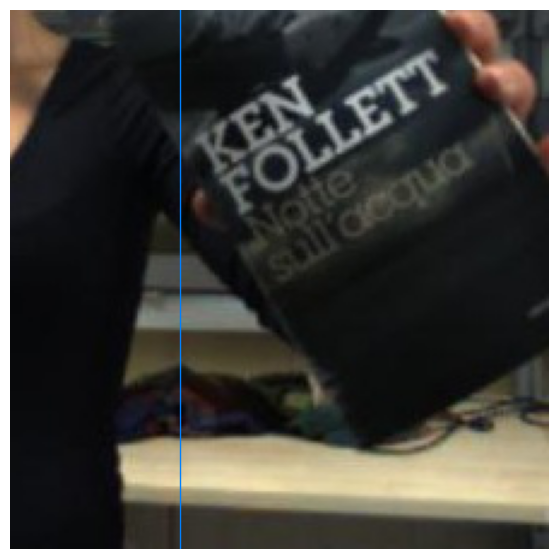

1/1 [==============================] - 0s 23ms/step
<class 'numpy.int32'>


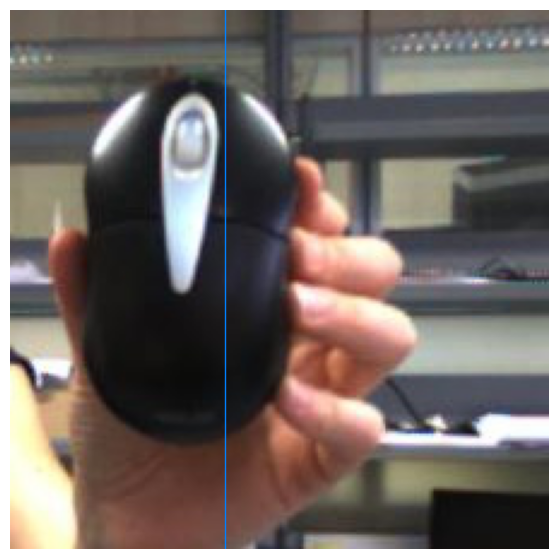

1/1 [==============================] - 0s 32ms/step
<class 'numpy.int32'>


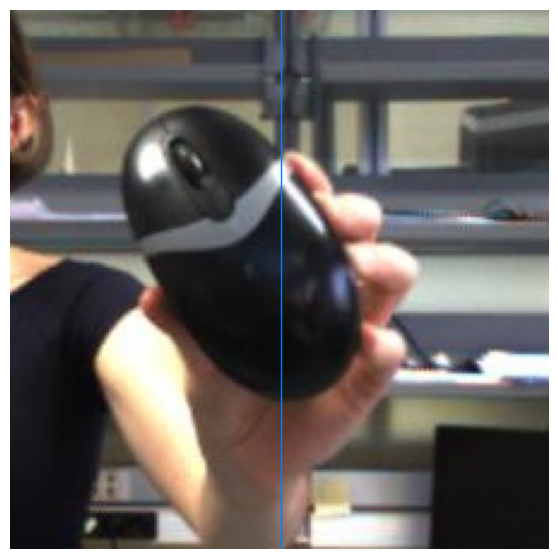

1/1 [==============================] - 0s 32ms/step
<class 'numpy.int32'>


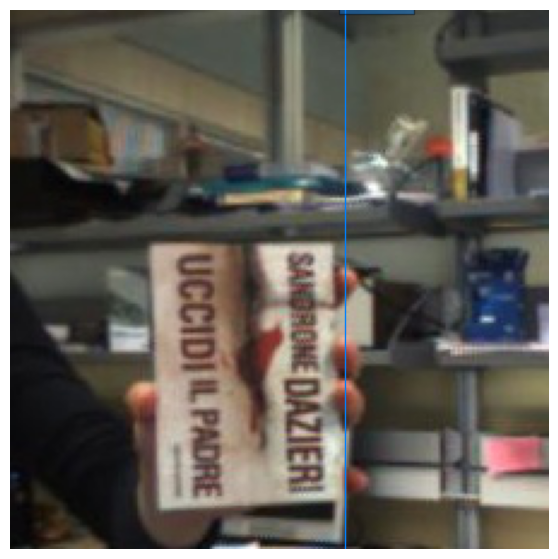

1/1 [==============================] - 0s 37ms/step
<class 'numpy.int32'>


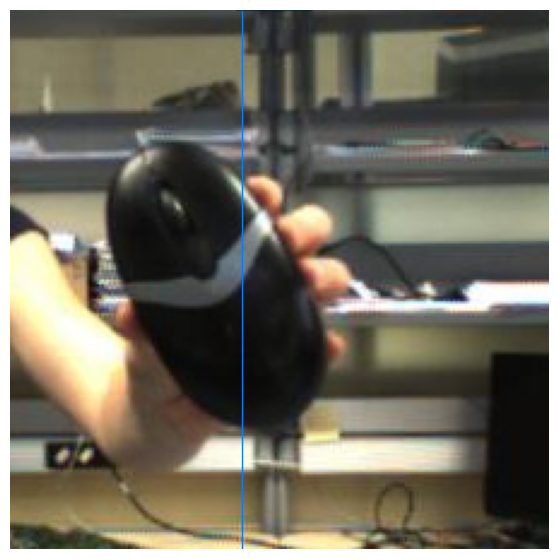

1/1 [==============================] - 0s 32ms/step
<class 'numpy.int32'>


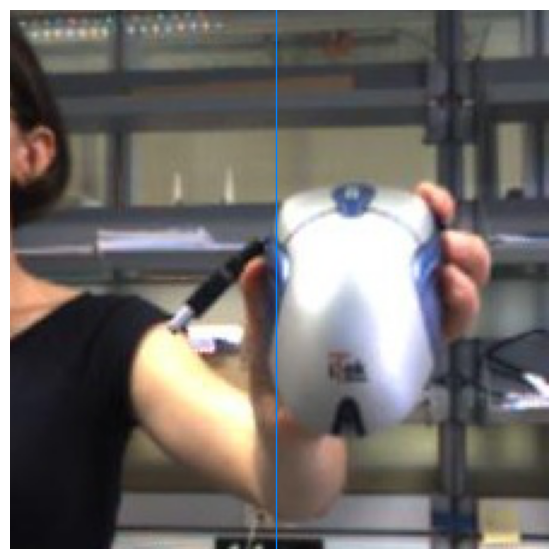

1/1 [==============================] - 0s 36ms/step
<class 'numpy.int32'>


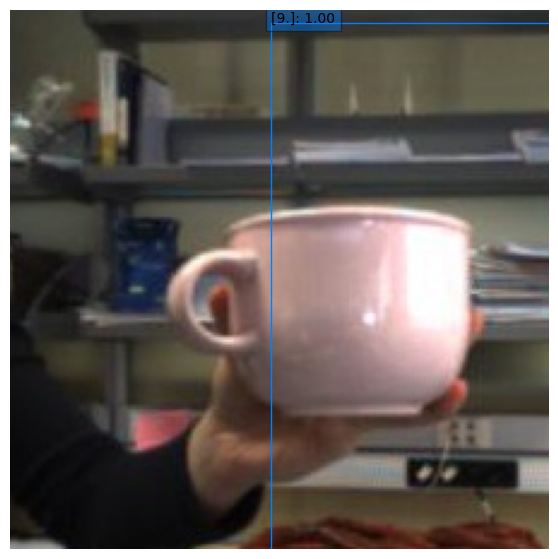

1/1 [==============================] - 0s 35ms/step
<class 'numpy.int32'>


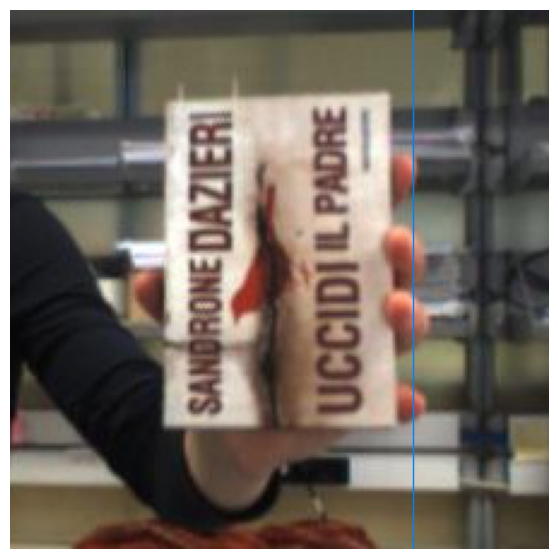

1/1 [==============================] - 0s 33ms/step
<class 'numpy.int32'>


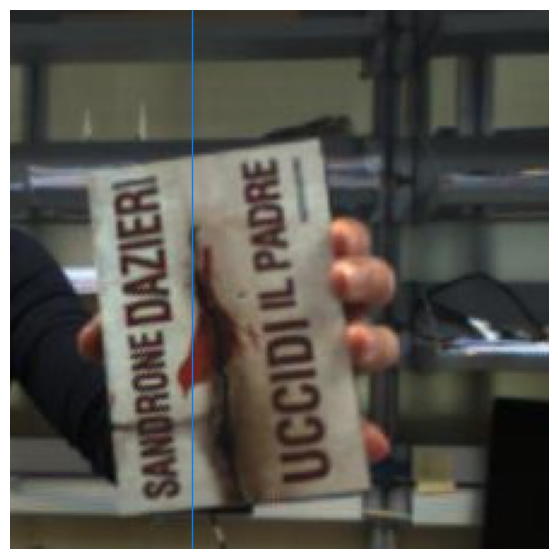

In [ ]:
def restore_original_image_from_array(x, data_format='channels_first'):
    mean = [103.939, 116.779, 123.68]

    # Zero-center by mean pixel
    if data_format == 'channels_first':
        if x.ndim == 3:
            x[0, :, :] += mean[0]
            x[1, :, :] += mean[1]
            x[2, :, :] += mean[2]
        else:
            x[:, 0, :, :] += mean[0]
            x[:, 1, :, :] += mean[1]
            x[:, 2, :, :] += mean[2]
    else:
        x[..., 0] += mean[0]
        x[..., 1] += mean[1]
        x[..., 2] += mean[2]

    if data_format == 'channels_first':
        # 'BGR'->'RGB'
        if x.ndim == 3:
            x = x[::-1, ...]
        else:
            x = x[:, ::-1, ...]
    else:
        # 'BGR'->'RGB'
        x = x[..., ::-1]

    return x



for image, annotation in val_dataset_pipe.unbatch().take(10):

  predictions = model.predict(tf.expand_dims(image, axis=0))
  cls, bbox, score= decode_prediction(predictions)

  bbox_decoded = convert_to_corners(bbox[:, 0,:4] * 224)  

  img = restore_original_image_from_array(image.numpy(), "channels_last")
  class_names = cls  

  visualize_detections(img ,bbox_decoded.numpy(), class_names, score ) 



<font color='red'>Comment the results on the test, what do you observe? what if you change learning rate and dimensions of the network</font> 